In [59]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import anndata as ad
import seaborn as sns; sns.set(color_codes=True)
import cupy as cp
import rapids_singlecell as rsc
import stlearn as st
import monkeybread as mb
from matplotlib.colors import to_hex
from matplotlib import cm
import os

import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

# clr normalization method courtesy of maximz
# https://github.com/scverse/scanpy/issues/1208
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata
# this function takes the qupath output file 
# returns an anndata
def qupath2Anndata(file_path):
    df = pd.read_csv(file_path, sep='\t', lineterminator='\n')

    # create the cell matrix
    df_mat = df[df.columns[df.columns.str.contains("Cell: Mean")]]
    # leave only protein names
    df_mat.columns = df_mat.columns.str.replace(': Cell: Mean', '')
    df_mat.index = df_mat.index + 1

    # create the metadata file
    df_meta = df[['Centroid X µm','Centroid Y µm','Nucleus: Area µm^2']].copy()
    # calculate the cytoplasm as the cell minus the nucleus
    df_meta.loc[:, 'Cytoplasm: Area µm^2'] = df['Cell: Area µm^2'].sub(df['Nucleus: Area µm^2'])
    # need to increase the index by 1 so that it doesn't start at 0
    df_meta.index = df_meta.index + 1

    spatial = df_meta[['Centroid X µm', 'Centroid Y µm']]
    spatial = spatial.rename(columns={'Centroid X µm': 'imagecol', 'Centroid Y µm': 'imagerow'})

    adata = st.create_stlearn(count=df_mat,spatial=spatial,
                                        library_id="Sample_test", scale=1,background_color="white")
    adata.obs['cellSize'] = df['Cell: Area µm^2'].values
    return adata
# this function returns the mean signal-to-noise
# ratio of the anndata
def getMeanSNR(expMat):
    tempSNR = []
    for j in range(np.shape(expMat)[1]):
        sorted_arr = np.sort(expMat[:, j])
        top20 = sorted_arr[-int(len(sorted_arr) * 0.2):]
        bottom10 = sorted_arr[:int(len(sorted_arr) * 0.1)]
        tempSNR.append(np.mean(top20) / np.mean(bottom10))
    #return np.mean(tempSNR)
    return tempSNR
# this function takes a list of lists and returns
# a stacked barplot used for cell proportion analysis
def plot_stacked_bar(list_of_lists, analysis_type, group_names, title_name, dir=None):
    # Flatten the list of lists
    flattened_list = [item for sublist in list_of_lists for item in sublist]

    # Get the unique phenotypes
    unique_phenotypes = list(set(flattened_list))

    # Create a dictionary to store the counts
    phenotype_counts = {phenotype: [0] * len(group_names) for phenotype in unique_phenotypes}

    # Count the occurrences of each phenotype for each group
    for i, group_list in enumerate(list_of_lists):
        for phenotype in group_list:
            phenotype_counts[phenotype][i] += 1

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(phenotype_counts, orient='index')
    df.columns = group_names

    # Normalize the counts for each group
    normalized_df = df.div(df.sum(axis=0), axis=1) * 100

    # Plot the stacked bar chart
    normalized_df.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(10, 5))
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.xlabel(analysis_type)
    plt.xticks(rotation=45)
    plt.ylabel("% Cell Types")
    plt.title(title_name + ' Cell Type Proportions by Niches')
    if dir:
        plt.savefig(os.path.join(dir, title_name+'_nicheprop.png'),bbox_inches='tight')
        plt.close()
    else:
        plt.show()
# this function returns a list of adatas from a list of files
# if no files list provided, it will read all txt from current dir
def load2Anndata(files=None):
    adatas = []
    if not files:
        files = [file for file in os.listdir() if file.endswith('.txt')]
    for i in range(len(files)):
        temp = qupath2Anndata(files[i])
        temp.obs['batch'] = files[i].split('.')[0]
        print(temp)
        adatas.append(temp)
    return adatas
# this function returns a plot of the meanSNRs for each gene given a list of adatas
def plotMeanSNR(adatas):
    snrs = []
    sample_names = []
    for a in adatas:
        snrs.append(getMeanSNR(a.X+0.1))
        sample_names.append(a.obs['batch'].unique()[0])
    data = {}
    for i in range(len(sample_names)):
        data[sample_names[i]] = snrs[i]
    data['Protein'] = adatas[0].var_names
    df = pd.DataFrame(data)
    plt.rcParams["figure.figsize"] = (20, 6)  # Increased width to accommodate legend
    fig, ax = plt.subplots()
    df.plot(x='Protein', kind='bar', stacked=False, logy=True, ax=ax)
    # Move legend outside and to the right
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # Adjust layout to prevent clipping of labels
    plt.tight_layout()
    plt.show()
# filters the anndatas using DAPI, fluorescence, and cell size
def filterAnndatas(adatas, channel_name='DAPI', DAPI_filter_val=10, fl_std_val=2, size_std_val=2, show_hist=True):
    for i in range(len(adatas)):
        # filter by DAPI
        print(len(adatas[i]))
        adatas[i] = adatas[i][adatas[i][:, channel_name].X > DAPI_filter_val, :]
        print(len(adatas[i]))
        
        # filter by fluorescence
        matrix = adatas[i].X
        cutoff_std = np.mean(np.log(np.sum(matrix, axis=1)))-fl_std_val*(np.std(np.log(np.sum(matrix, axis=1))))
        if show_hist:
            plt.hist(np.log(np.sum(matrix, axis=1)), bins=50, edgecolor='black')
            plt.ylabel('Frequency')
            plt.xlabel('Log Scaled Total Fluorescence Per Cell')
            plt.axvline(x=cutoff_std, color='red', linestyle='--')
            plt.show()
        idx = np.where(np.log(np.sum(matrix, axis=1)) > cutoff_std)[0]
        adatas[i] = adatas[i][idx,:]

        # filter by cell size
        cellSizes = adatas[i].obs['cellSize'].values
        cutoff_std = np.mean(np.log(cellSizes))+size_std_val*(np.std(np.log(cellSizes)))
        if show_hist:
            plt.hist(np.log(cellSizes), bins=50, edgecolor='black')
            plt.ylabel('Frequency')
            plt.xlabel('Log Scaled Cell Sizes')
            plt.axvline(x=cutoff_std, color='red', linestyle='--')
            plt.show()
        idx = np.where(np.log(cellSizes) < cutoff_std)[0]
        adatas[i] = adatas[i][idx,:]

        st.pl.QC_plot(adatas[i])
    return adatas
# this function removes genes provided a list of gene names
def removeGenes(adatas, genes_to_remove=['DAPI']):
    for i in range(len(adatas)):
        adatas[i] = adatas[i][:,~adatas[i].var_names.isin(genes_to_remove)]
    return adatas
# this function performs CLR normalization on all adatas
def clrNormalizeAnndatas(adatas):
    for i in range(len(adatas)):
        clr_normalize_each_cell(adatas[i])
    return adatas
# this function merges the anndatas and save it as a h5ad for batch correction
def mergeNSave(adatas, file_name):
    adata = ad.concat(adatas, uns_merge='first')
    adata.write_h5ad(file_name+'.h5ad')
# this function conducts leiden clustering on UMAP and generate a dotplot for cell annotation
def clusterNDotPlot(adata, n_comps=None, n_neighbors=30, resolution=0.5, figsize=(6,4), dpi=(100), dotsize=3):
    if not n_comps:
        n_comps = len(adata.var)
    if 'X_pca_harmony' in adata.obsm:
        adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
    else:
        rsc.pp.pca(adata, n_comps=n_comps)
    rsc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_comps, use_rep='X_pca')
    rsc.tl.umap(adata)
    rsc.tl.leiden(adata, resolution=resolution)
    with plt.rc_context({"figure.figsize": figsize, "figure.dpi": dpi}):
        sc.pl.umap(adata, color=['leiden', 'batch'], size=dotsize)
    st.pp.scale(adata)
    sc.pl.dotplot(adata, adata.var_names.to_list(), groupby='leiden', dendrogram=False, log=True, cmap='RdBu_r')
    return adata
# this function generates a cluster map
def clusterMap(adata, color='leiden'):
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    sc.pl.embedding(adata, "spatial", color=color, s=20, ax=ax, show=False,)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    plt.show()
# this function takes a list of annotations and maps it onto the Leiden clusterings
def manualAnnotateCells(adata, annotations, figsize=(6,6), dpi=(100), dotsize=5):
    adata.obs['cellType'] = ''
    adata.obs['cellType'] = adata.obs['cellType'].astype(str)

    i = 0
    for c in np.sort(adata.obs['leiden'].astype(int).unique()):
        adata.obs.loc[adata.obs['leiden'] == str(c), 'cellType'] = annotations[i]
        i = i+1
    with plt.rc_context({"figure.figsize": figsize, "figure.dpi": dpi}):
        sc.pl.umap(adata, color=['cellType'], size=dotsize)
    sc.pl.dotplot(adata, adata.var_names.to_list(), groupby='cellType', dendrogram=False, cmap='viridis')

    return adata
# this function conducts niche analysis on your anndata
# niches are generated separately by batch
def monkeyNiche(adata):
    adata_niches = []
    counter = 1
    for tma in adata.obs['batch'].unique():
        adata_sub = adata[adata.obs['batch']==tma]
        niche_subtypes = []
        for cell, ct in zip(adata_sub.obs.index, adata_sub.obs['cellType']):
            niche_subtypes.append(ct)
        adata_sub.obs['niche_subtypes'] = niche_subtypes
        adata_sub.obs['niche_subtypes'] = adata_sub.obs['niche_subtypes'].astype('category')
        adata_sub.obsm['X_spatial'] = adata_sub.obsm['spatial']

        # none mask is broken in the code, this gets around it
        mask = ~adata_sub.obs['niche_subtypes'].isin([])
        # Compute niches
        adata_sub_neighbors = mb.calc.cellular_niches(adata_sub,cell_type_key='niche_subtypes',
            radius=75,normalize_counts=False,standard_scale=False,clip_min=-1000,clip_max=1000,mask=mask,
            n_neighbors=30,resolution=0.1,min_niche_size=300,key_added='niche',non_niche_value='other')
        adata_niches.append(adata_sub)

        # progress update lol
        print(str(int(counter*100/len(adata.obs['batch'].unique()))) + '% Complete!')
        counter=counter+1

    adata_niche = ad.concat(adata_niches, uns_merge='first')
    adata.obs['niche'] = adata_niche.obs['niche']
    adata.obs['niche_subtypes'] = adata_niche.obs['niche_subtypes']
    return adata
# this function collapses niches generated from individual batches
# using clustering such that it finds common niches across samples
def collapseNiche(adata, resolution=0.5):
    # collapse the niches together
    dfs = []
    for tma in adata.obs['batch'].unique():
        temp = adata[adata.obs['batch']==tma]
        niche_names = sorted(list(temp.obs['niche'].unique()), key=lambda x: (x=='other', int(x) if x != 'other' else float('inf')))
        niche_names_unique = [(tma + '_') + item if item != 'other' else item for item in niche_names]
        cts = []
        for n in niche_names:
            tempn = temp[temp.obs['niche']==n]
            cts.append(list(tempn.obs['cellType'].values))
        flattened_list = [item for sublist in cts for item in sublist]
        # Get the unique phenotypes
        unique_phenotypes = list(set(flattened_list))
        # Create a dictionary to store the counts
        phenotype_counts = {phenotype: [0] * len(niche_names) for phenotype in unique_phenotypes}
        # Count the occurrences of each phenotype for each group
        for i, group_list in enumerate(cts):
            for phenotype in group_list:
                phenotype_counts[phenotype][i] += 1
        # Convert the dictionary to a DataFrame
        df = pd.DataFrame.from_dict(phenotype_counts, orient='index')
        df.columns = niche_names_unique
        # Normalize the counts for each group
        normalized_df = df.div(df.sum(axis=0), axis=1) * 100
        if 'other' in normalized_df.columns:
            normalized_df = normalized_df.drop('other', axis=1)
        dfs.append(normalized_df)
    nicheprop_mat = pd.concat(dfs, axis=1, join='outer').fillna(0).T
    ad_nicheprop = ad.AnnData(X=nicheprop_mat.values,
                            obs=pd.DataFrame(index=nicheprop_mat.index, data={'niche': nicheprop_mat.index}),
                            var=pd.DataFrame(index=nicheprop_mat.columns))
    rsc.pp.pca(ad_nicheprop, n_comps=len(ad_nicheprop.var))
    rsc.pp.neighbors(ad_nicheprop, n_neighbors=10, n_pcs=len(ad_nicheprop.var), use_rep='X_pca')
    rsc.tl.umap(ad_nicheprop)
    rsc.tl.leiden(ad_nicheprop, resolution=resolution)
    sc.pl.umap(ad_nicheprop, color=['leiden'], size=700)

    adata.obs['nicheCollapsed'] = ''
    adata.obs['nicheCollapsed'] = adata.obs['nicheCollapsed'].astype(str)
    for tma in adata.obs['batch'].unique():
        temp = adata[adata.obs['batch']==tma]
        for n in temp.obs['niche'].unique():
            if n != 'other':
                niche_code = tma+'_'+n
                new_niche = ad_nicheprop[ad_nicheprop.obs['niche']==niche_code].obs['leiden'].values[0]
                mask = (adata.obs['batch'] == tma) & (adata.obs['niche']==n)
                adata.obs.loc[mask, 'nicheCollapsed'] = new_niche
            else:
                mask = (adata.obs['batch'] == tma) & (adata.obs['niche']==n)
                adata.obs.loc[mask, 'nicheCollapsed'] = 'other'
                                
    return adata

/home/lzhang36/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 74120 × 16
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


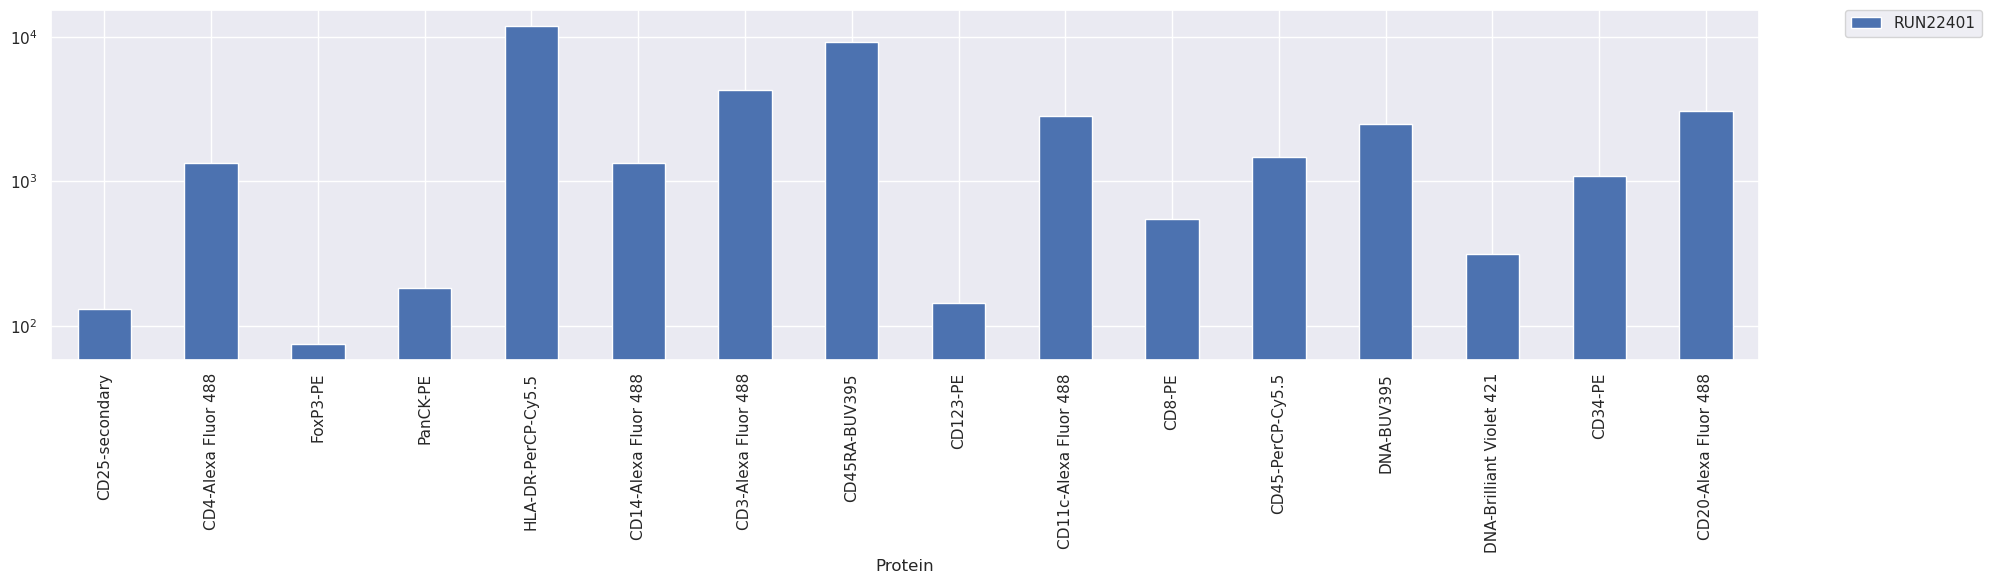

74120
40788


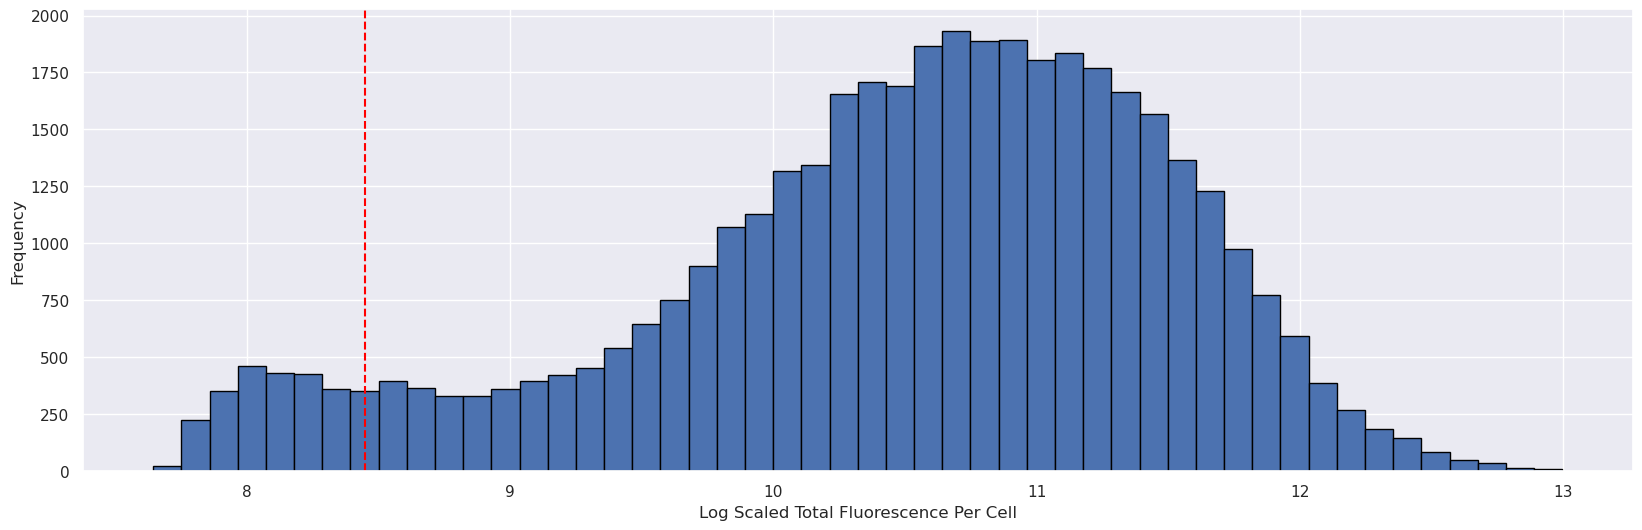

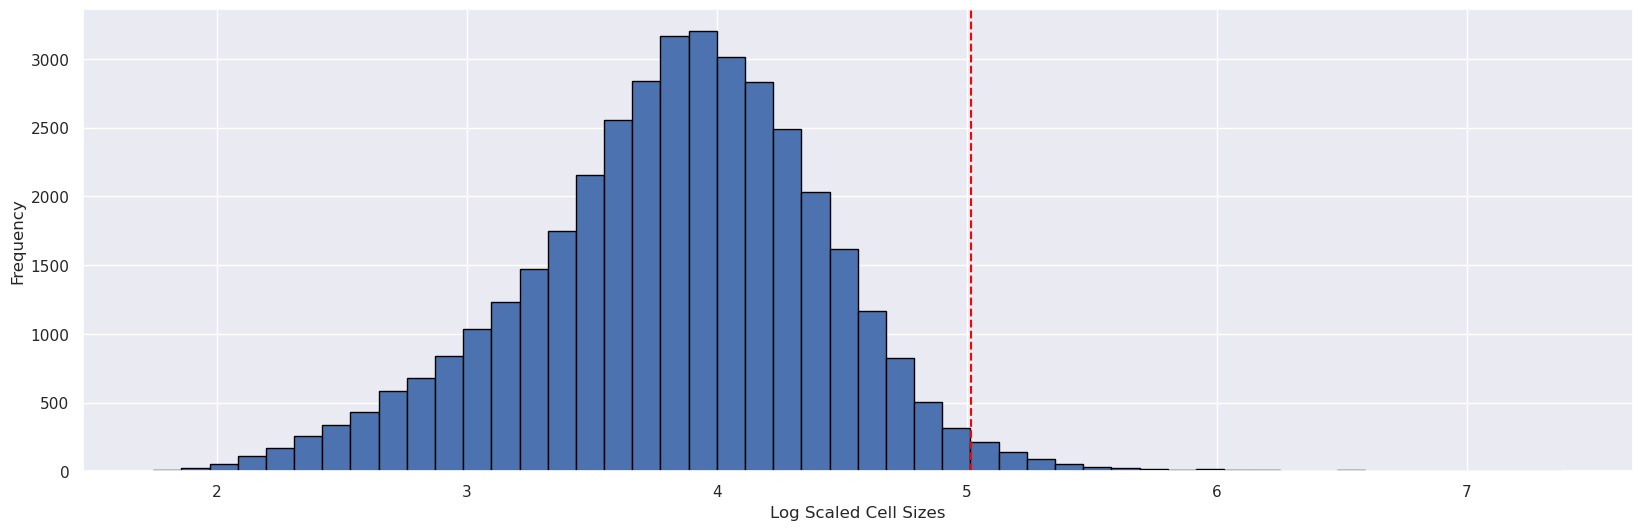

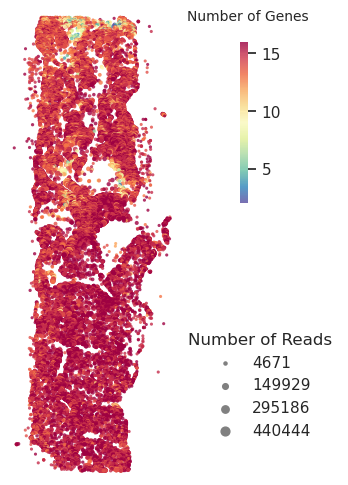

In [68]:
# loading and preprocessing
adatas = load2Anndata()
plotMeanSNR(adatas)
adatas = filterAnndatas(adatas, channel_name='DNA-Brilliant Violet 421', DAPI_filter_val=2000, show_hist=True)
adatas = removeGenes(adatas, genes_to_remove=['DNA-Brilliant Violet 421', 'DNA-BUV395'])
adatas = clrNormalizeAnndatas(adatas)
mergeNSave(adatas, 'adata')

*BATCH CORRECTION COMMANDS*


export NUM_THREADS=1 export OPENBLAS_NUM_THREADS=1 export OMP_NUM_THREADS=1 
python RunHarmony.py adata.h5ad adata.h5ad

/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


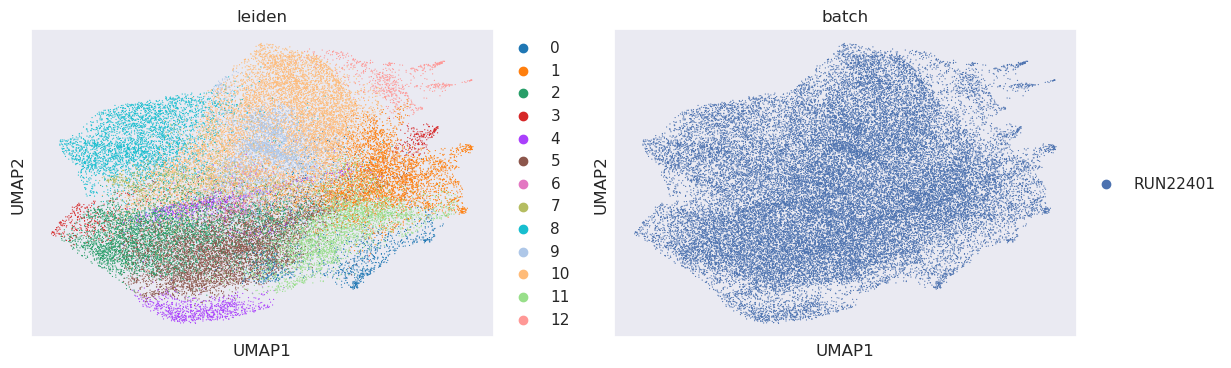

Scale step is finished in adata.X


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


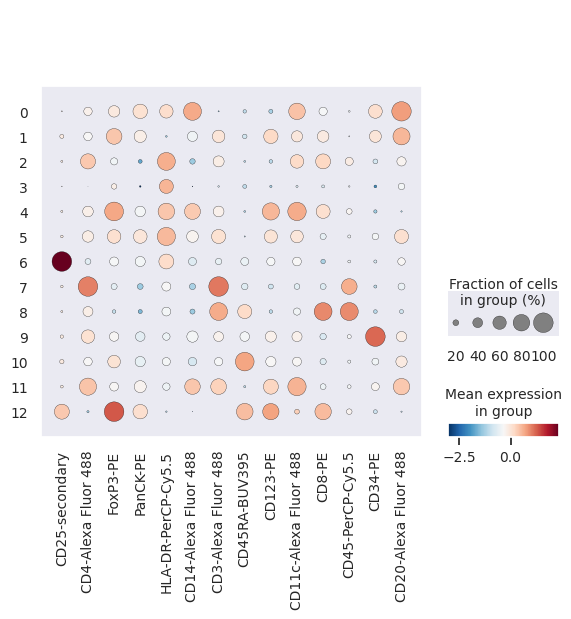

/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


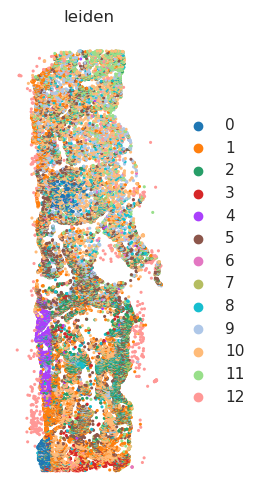

In [44]:
# conduct clustering and generate dotplot
adata = ad.read_h5ad('adata.h5ad')
adata = clusterNDotPlot(adata)
clusterMap(adata)

/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


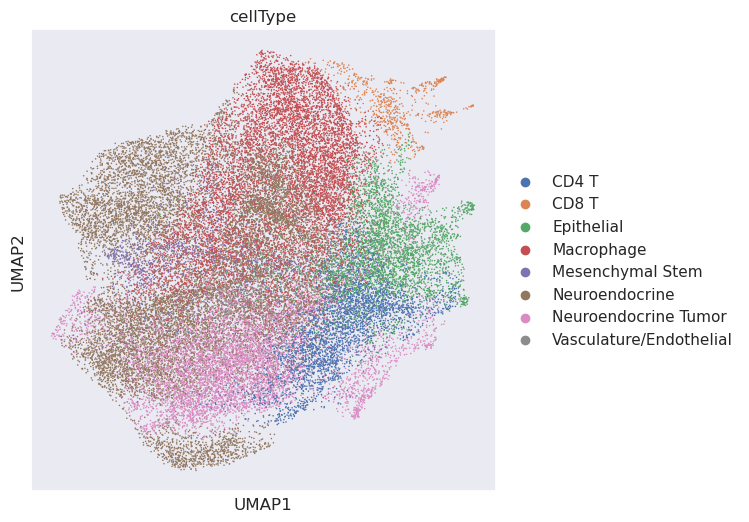

/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


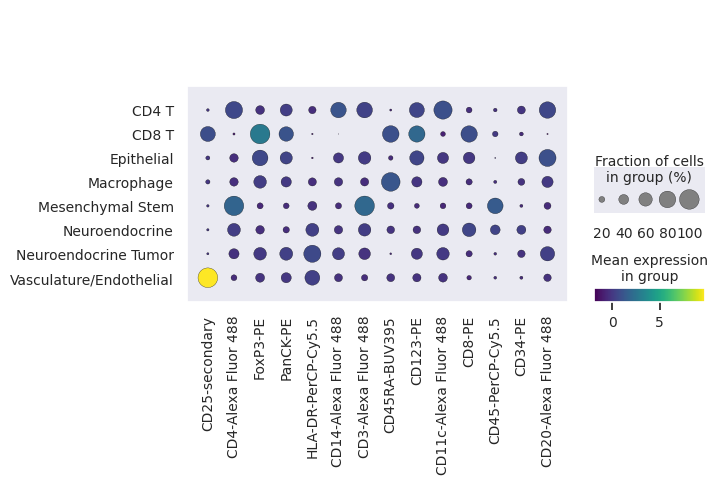

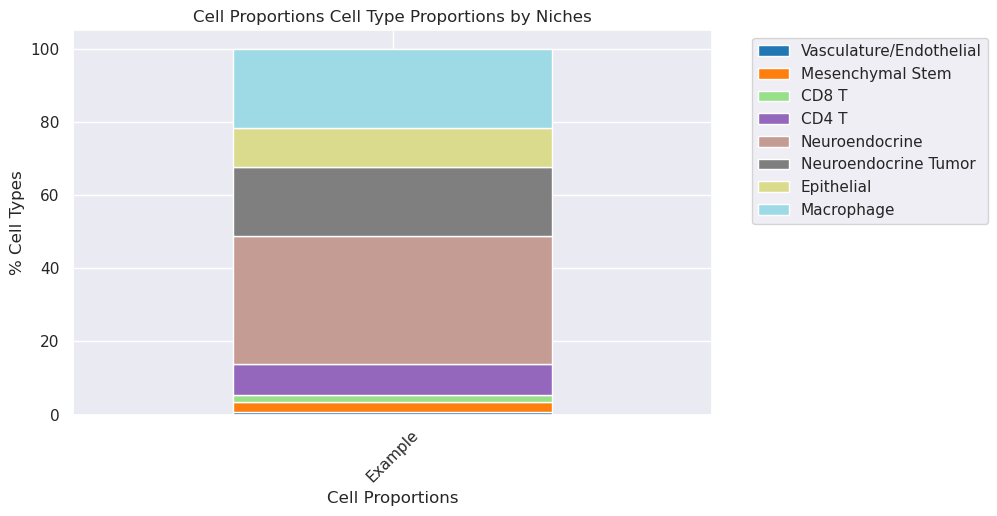

In [57]:
# annotations and cell proportion analysis
annotations = ['Neuroendocrine Tumor', 'Epithelial', 'Neuroendocrine', 'Neuroendocrine Tumor',
                'Neuroendocrine', 'Neuroendocrine Tumor', 'Vasculature/Endothelial', 'Mesenchymal Stem',
                'Neuroendocrine', 'Neuroendocrine', 'Macrophage', 'CD4 T', 'CD8 T',]
adata = manualAnnotateCells(adata, annotations=annotations)

typeOfCells= adata.obs['cellType'].values
list_of_lists = [typeOfCells]
group_names = ['Example']
plot_stacked_bar(list_of_lists, analysis_type = 'Cell Proportions', group_names=group_names, title_name='Cell Proportions')

/tmp/ipykernel_2494991/526965510.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sub.obs['niche_subtypes'] = niche_subtypes


Computing neighborhood profiles...


/home/lzhang36/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Clustering neighborhood profiles...
Generating niches...
100% Complete!


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


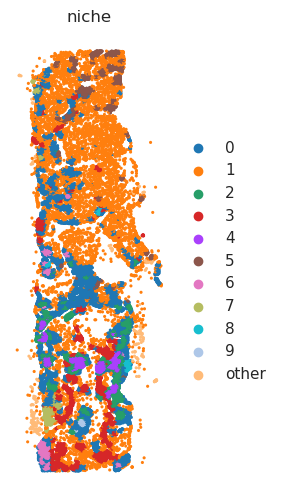

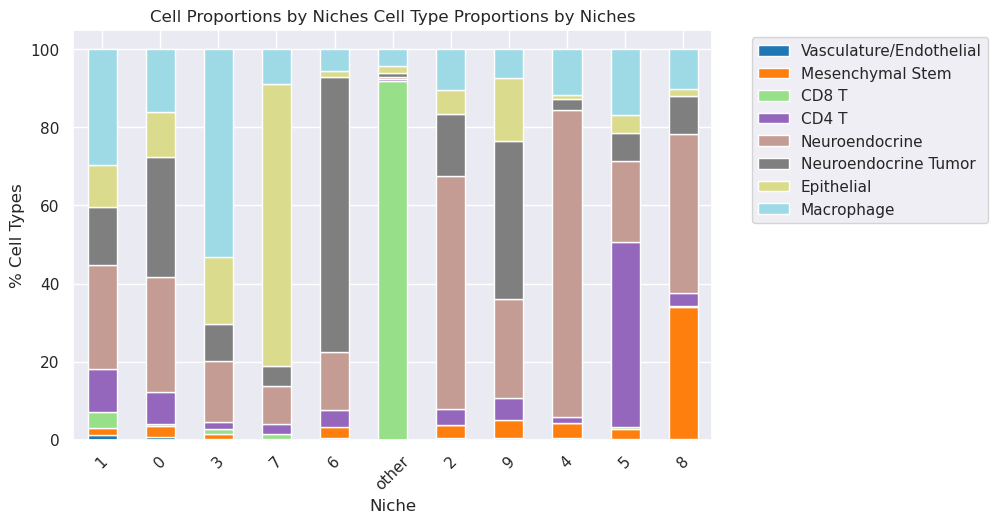

In [67]:
# niche analysis
adata = monkeyNiche(adata)
clusterMap(adata, color='niche')

list_of_lists = []
group_names = []
for n in adata.obs['niche'].unique():
    list_of_lists.append(adata[adata.obs['niche']==n].obs['cellType'].values)
    group_names.append(n)
plot_stacked_bar(list_of_lists, analysis_type = 'Niche', group_names=group_names, title_name='Cell Proportions by Niches')